# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [1]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image
from imgclas import paths, plot_utils

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

# User parameters to set
TIMESTAMP = '2021-11-03_Lab_All_CopasVasos_All_reg'       # timestamp of the model
# SPLIT_NAME = 'testLaRiojaICVVCopasAll'                   # dataset split to predict
SPLIT_NAME = 'Voluntarios_enero'
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}.json'.format(MODEL_NAME, SPLIT_NAME))
with open(pred_path) as f:
    pred_dict = json.load(f)

## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [2]:
from imgclas import test_utils
import sklearn.metrics as metrics
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b

y, yhat = np.array(pred_dict['true_value']), np.array(pred_dict['pred_value'])

mae = metrics.mean_absolute_error(y, yhat)
mse = metrics.mean_squared_error(y, yhat)
rmse = np.sqrt(mse) # or mse**(0.5)  
r2 = metrics.r2_score(y,yhat)

print("MAE:",mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R-Squared:", r2)

MAE: 32.869621442711875
MSE: 1729.7616499606331
RMSE: 41.59040333972049
R-Squared: -1.0911140400301713


## Visualization

See worst predicted images and check if there is a pattern. We will consider those that were predicted for a different class than the true one.

In [12]:
# compare predicted values with true values and calculate relative error
rel_err=[]
for i in range(len(pred_dict['true_value'])):
    rel_err.append(abs(pred_dict['pred_value'][i] - pred_dict['true_value'][i])/pred_dict['true_value'][i])

In [17]:
wrong_predictions=[]
for i in range(len(pred_dict['true_value'])):
    if rel_err[i]>0.9:
        wrong_predictions.append(pred_dict['filenames'][i])
len(wrong_predictions)

9

In [18]:
wrong_predictions

['/srv/datos/imagenes_CNN/0addbab7-fb3a-4768-82e3-590a42e2f122_madrid_crianza_50_copa_burd_almuerzo_05-12-2021_14-49-08.jpg',
 '/srv/datos/imagenes_CNN/9a4bbc89-d0e6-4a7c-98af-2e588d9ae21b_otra_crianza_100_copa_chard_fuera_29-05-2021_18-30-51.jpg',
 '/srv/datos/imagenes_CNN/8fddaf67-5dee-4a9a-8268-0fa75ce396f8_madrid_crianza_100_duralex_almuerzo_18-11-2021_09-30-03.jpeg',
 '/srv/datos/imagenes_CNN/fc10958e-5328-4274-b876-6cd04be4a907_madrid_crianza_50_copa_cata_almuerzo_21-11-2021_12-50-05.jpg',
 '/srv/datos/imagenes_CNN/6853afb2-aee1-4d11-a719-0f7d34389acb_otra_crianza_50_copa_burd_almuerzo_14-06-2021_06-28-56.jpg',
 '/srv/datos/imagenes_CNN/0addbab7-fb3a-4768-82e3-590a42e2f122_madrid_crianza_50_copa_burd_almuerzo_05-12-2021_14-48-35.jpg',
 '/srv/datos/imagenes_CNN/0addbab7-fb3a-4768-82e3-590a42e2f122_madrid_joven_50_copa_burd_cena_05-12-2021_21-40-00.jpg',
 '/srv/datos/imagenes_CNN/9a4bbc89-d0e6-4a7c-98af-2e588d9ae21b_otra_crianza_100_copa_chard_fuera_30-05-2021_11-40-44.jpg',
 '/srv

In [3]:
'''
Round a number to the closer 25th (i.e. 0, 25, 50, 75, etc.)

It is important to note that x.5 will be rounded to x instead of x+1 in the current 3.6.8 Python version.
For more details see https://stackoverflow.com/questions/10825926/python-3-x-rounding-behavior
'''

def myround(x, base=25):
    return round(base * round(float(x)/base))

In [4]:
# save images that are wrong predicted in a list,
# to see if they share a pattern
right_predictions=[]
for i in range(len(pred_dict['true_value'])):
    if myround(pred_dict['pred_value'][i])==pred_dict['true_value'][i]:
        right_predictions.append(pred_dict['filenames'][i])

In [5]:
# save images that are wrong predicted in a list,
# to see if they share a pattern
wrong_predictions=[]
for i in range(len(pred_dict['true_value'])):
    if myround(pred_dict['pred_value'][i])!=pred_dict['true_value'][i]:
        wrong_predictions.append(pred_dict['filenames'][i])

In [6]:
len(wrong_predictions) # de 138 fotos de voluntarios solo predice en la clase correcta 107

107

## Saliency maps

In [7]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=True)

# FILEPATH = '/srv/datos/Voluntarios/5c61f838-32bc-4faa-858d-a215981d0618_otra_crianza_125_copa_cata_almuerzo_14-06-2021_13-22-58.jpg'
def plot_saliency_maps(FILEPATH):
    saliency_types = [GradientSaliency, IntegratedGradients] # --> VisualBackprop seems to give errors
    # https://stackoverflow.com/questions/52606751/invalidargumenterror-input-10-is-both-fed-and-fetched posible solucion al error

    figsize = 5
    fig, axs = plt.subplots(2, len(saliency_types)+1, figsize=(figsize*(len(saliency_types)+1), figsize*2))
    axs = axs.T.flatten()

    # Load the image and preprocess it for the saliency maps computation
    data_gen = k_crop_data_sequence(inputs=[FILEPATH],
                                im_size=conf['model']['image_size'],
                                mean_RGB=conf['dataset']['mean_RGB'],
                                std_RGB=conf['dataset']['std_RGB'],
                                preprocess_mode=conf['model']['preprocess_mode'],
                                aug_params=None,
                                crop_mode='random',
                                crop_number=1)#,
                                #filemode='local')

    img_arr = data_gen.__getitem__(0)
    img_arr = img_arr.squeeze(axis=0)

    # Original image
    image = data_utils.load_image(FILEPATH)#, filemode='local')
    image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])
    axs[0].imshow(image)
    axs[0].set_title('Original image', fontsize=12)
    fig.delaxes(axs[1])
    axs = axs[2:]

    # Saliency maps
    axs[0].set_ylabel('Standard', fontsize=12)
    axs[1].set_ylabel('Smoothed', fontsize=12)
    for i, f in enumerate(saliency_types):
        print('[{}/{}] {}'.format(i+1, len(saliency_types), f.__name__))
        saliency_func = f(model)
    
        # Normal map
        mask = saliency_func.get_mask(img_arr)
        mask = np.sum(np.abs(mask), axis=2)
        axs[i*2].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
        axs[i*2].set_title(saliency_func.__class__.__name__, fontsize=12)
    
        # Smoothgrad map
        mask = saliency_func.get_smoothed_mask(img_arr) # el error esta en get_smoothed_mask de visual_backprop
        mask = np.sum(np.abs(mask), axis=2)
        axs[i*2+1].imshow(mask, cmap=plt.cm.gray, vmin=np.amin(mask), vmax=np.percentile(mask, 98))
    
    # Print predicted labels
    pred_value = predict(model, FILEPATH, conf)#, filemode='local')
    print('Predicted value:')
    print('{}'.format(pred_value[0]))

W0127 13:00:14.640335 139822738347840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0127 13:00:14.642297 139822738347840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0127 13:00:14.644063 139822738347840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 1s 1s/step
Predicted value:
150.10073852539062


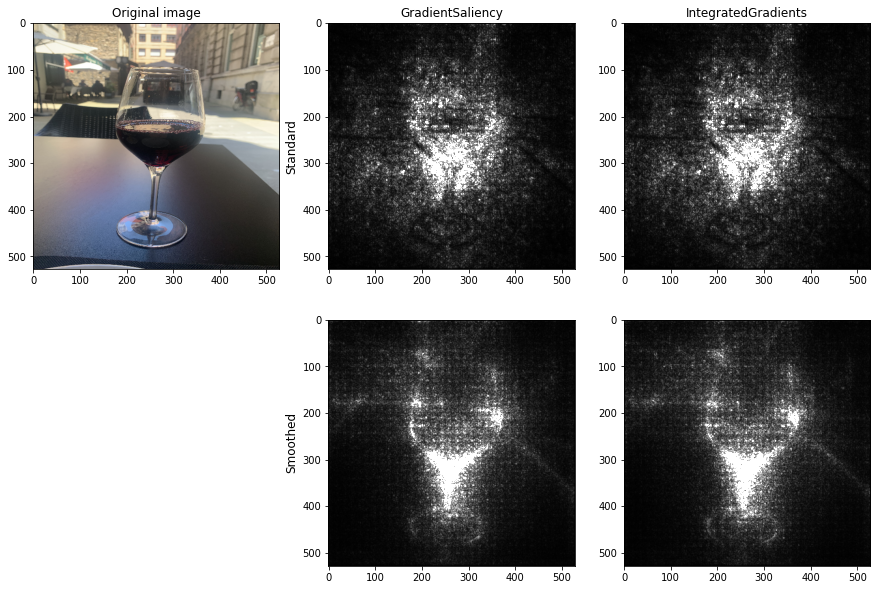

In [26]:
FILEPATH = '/srv/datos/imagenes_CNN/77a8efd5-2a40-411e-9e58-c403a27e15c8_otra_reserva_75_copa_borg_almuerzo_12-06-2021_11-31-47.jpeg'
plot_saliency_maps(FILEPATH)

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 3s 3s/step
Predicted value:
200.15496826171875


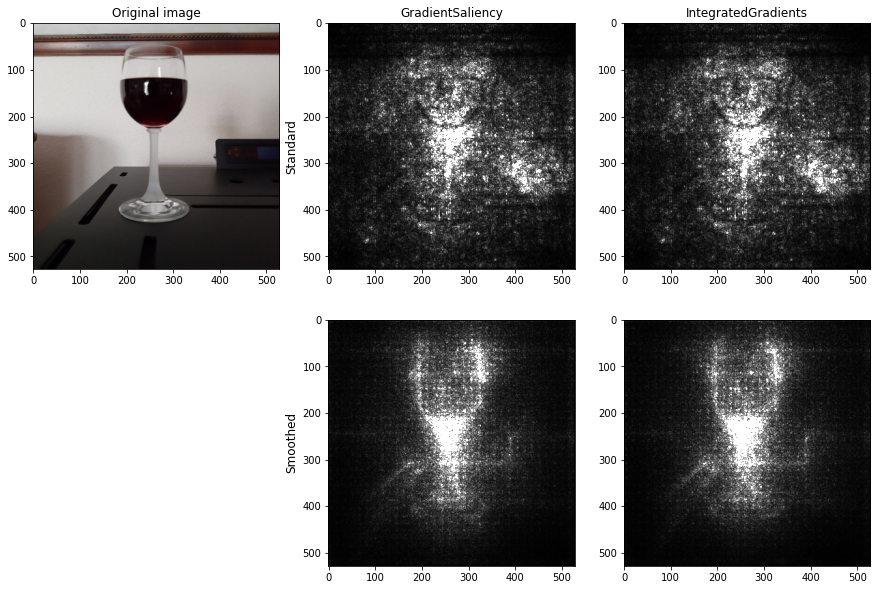

In [25]:
FILEPATH = '/srv/datos/imagenes_CNN/9a4bbc89-d0e6-4a7c-98af-2e588d9ae21b_otra_crianza_100_copa_chard_fuera_30-05-2021_11-40-44.jpg'
plot_saliency_maps(FILEPATH)

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
127.11740112304688


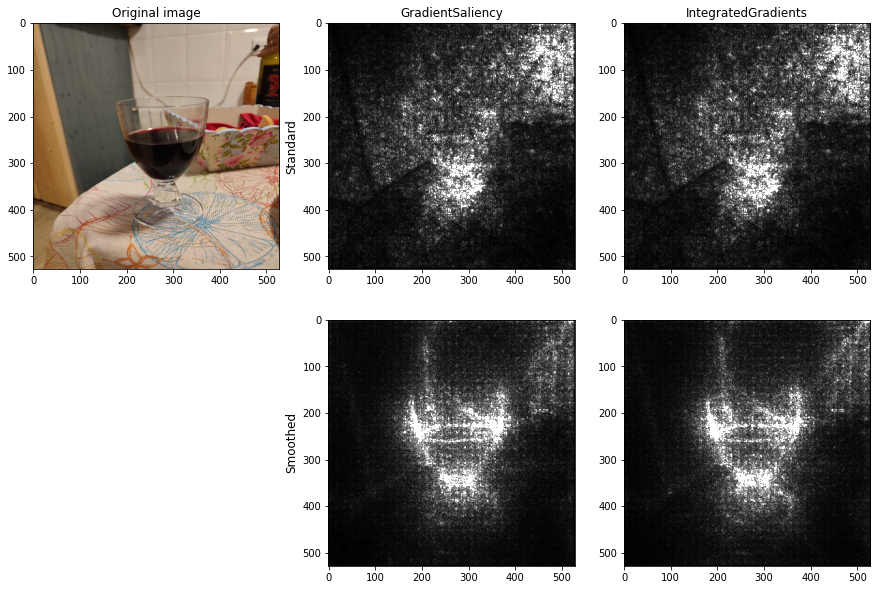

In [24]:
FILEPATH = '/srv/datos/imagenes_CNN/0addbab7-fb3a-4768-82e3-590a42e2f122_madrid_joven_50_copa_burd_cena_05-12-2021_21-40-00.jpg'
plot_saliency_maps(FILEPATH)

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
101.56051635742188


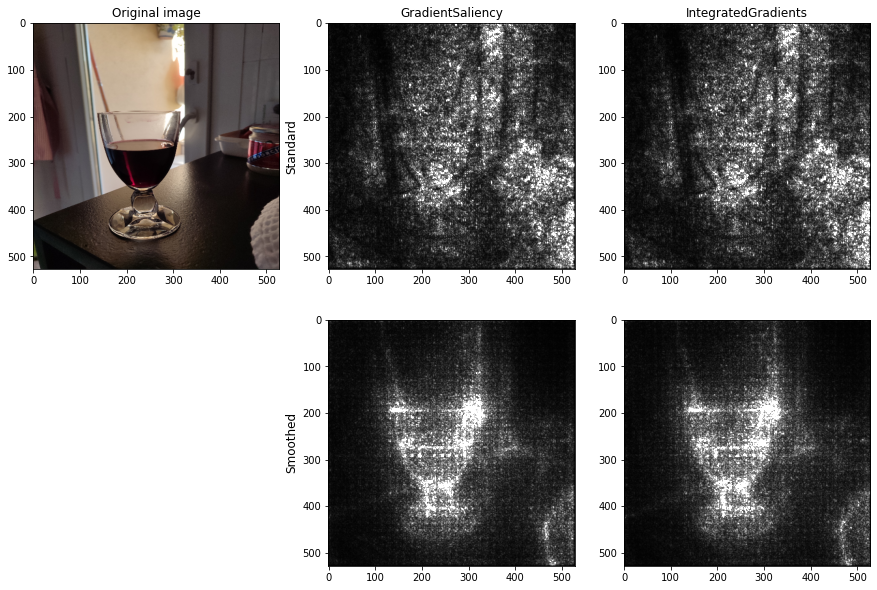

In [23]:
FILEPATH = '/srv/datos/imagenes_CNN/0addbab7-fb3a-4768-82e3-590a42e2f122_madrid_crianza_50_copa_burd_almuerzo_05-12-2021_14-48-35.jpg'
plot_saliency_maps(FILEPATH)

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 1s 1s/step
Predicted value:
162.3112030029297


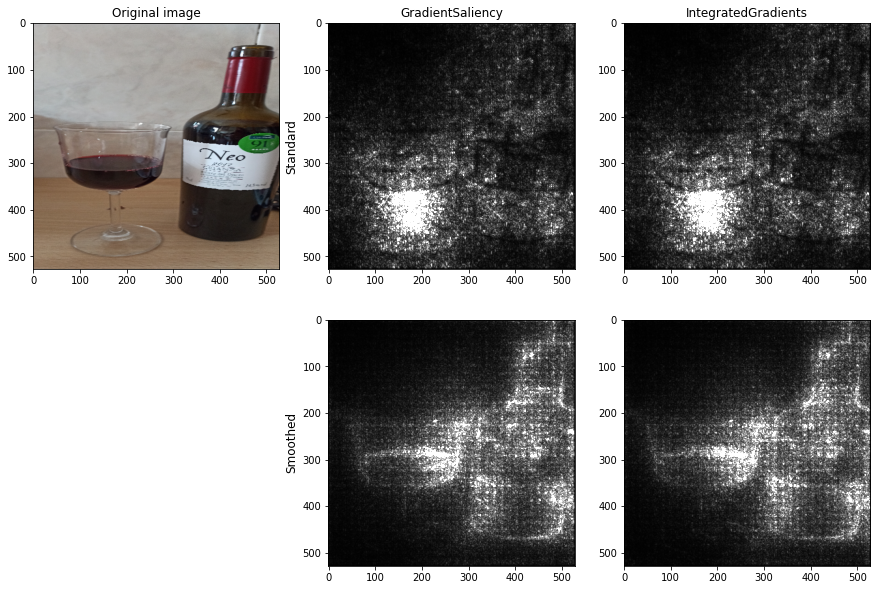

In [22]:
FILEPATH = '/srv/datos/imagenes_CNN/6853afb2-aee1-4d11-a719-0f7d34389acb_otra_crianza_50_copa_burd_almuerzo_14-06-2021_06-28-56.jpg'
plot_saliency_maps(FILEPATH)

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
195.59552001953125


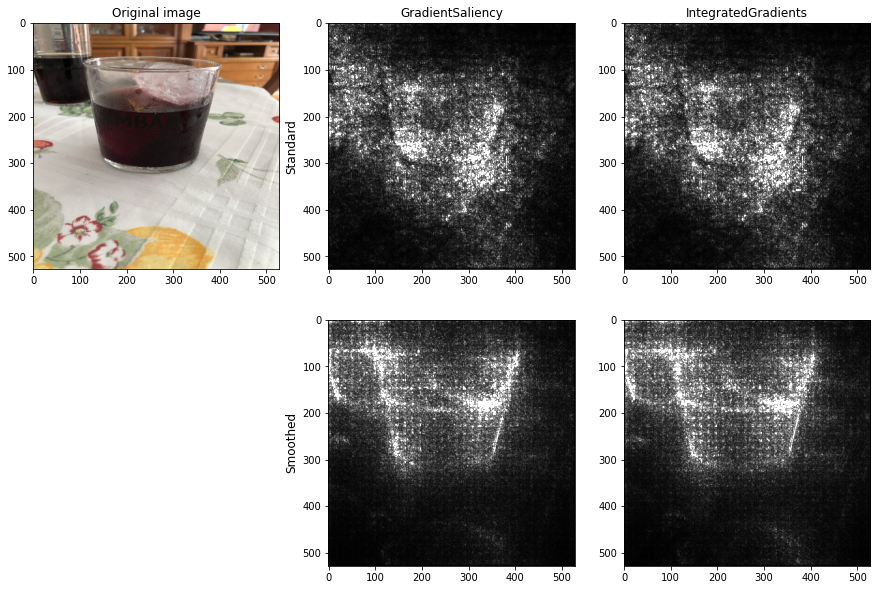

In [21]:
FILEPATH = '/srv/datos/imagenes_CNN/8fddaf67-5dee-4a9a-8268-0fa75ce396f8_madrid_crianza_100_duralex_almuerzo_18-11-2021_09-30-03.jpeg'
plot_saliency_maps(FILEPATH)

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
215.91835021972656


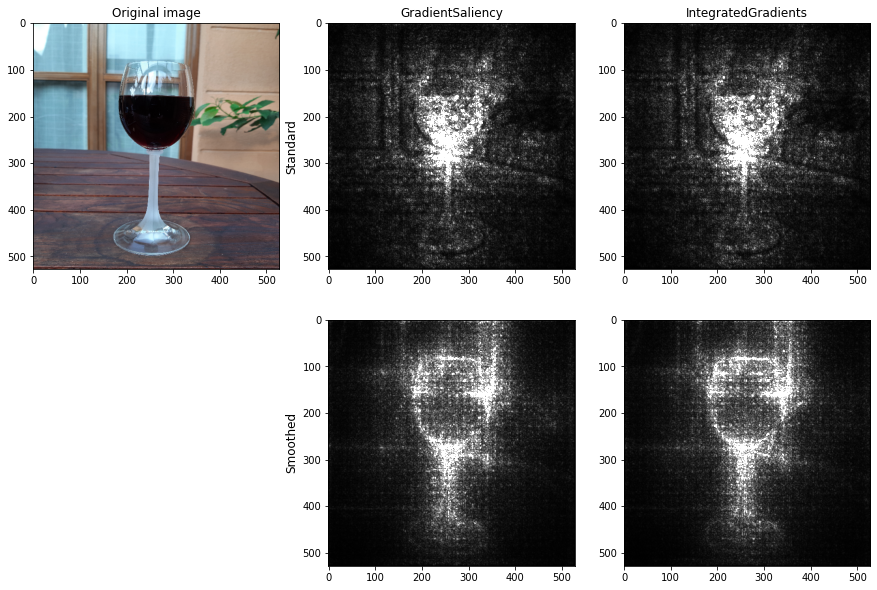

In [20]:
FILEPATH = '/srv/datos/imagenes_CNN/9a4bbc89-d0e6-4a7c-98af-2e588d9ae21b_otra_crianza_100_copa_chard_fuera_29-05-2021_18-30-51.jpg'
plot_saliency_maps(FILEPATH)

[1/2] GradientSaliency
[2/2] IntegratedGradients
1/1 [==============================] - 2s 2s/step
Predicted value:
101.56051635742188


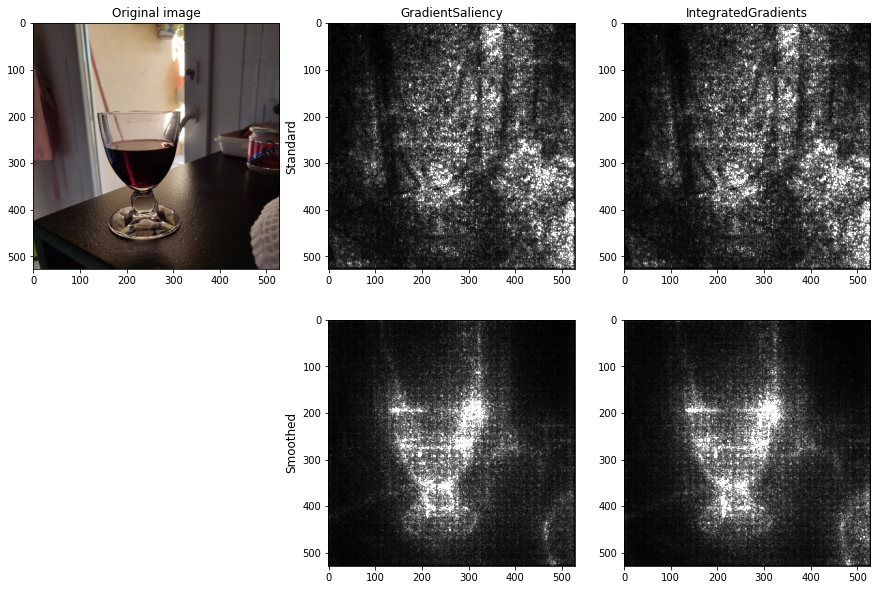

In [19]:
FILEPATH = '/srv/datos/imagenes_CNN/0addbab7-fb3a-4768-82e3-590a42e2f122_madrid_crianza_50_copa_burd_almuerzo_05-12-2021_14-49-08.jpg'
plot_saliency_maps(FILEPATH)